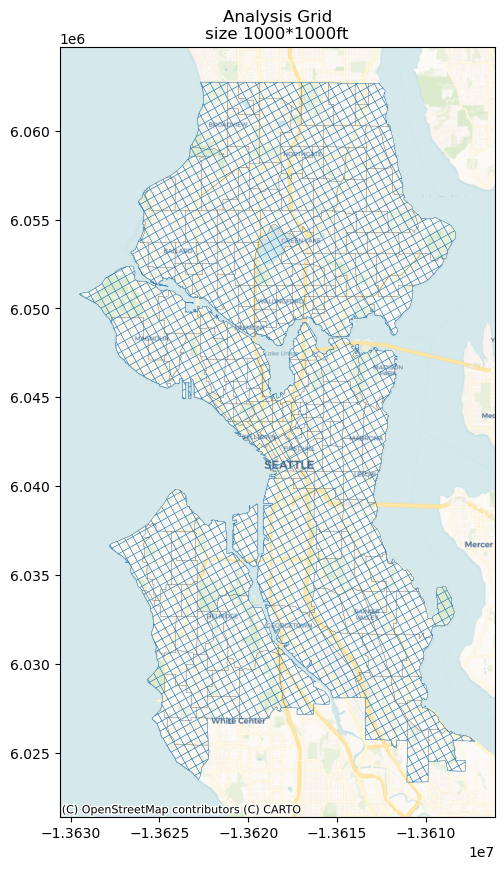

In [72]:
# Required Libraries
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from contextily import add_basemap
import contextily as cx

# 加载seattle boundary
seattle_boundary = gpd.read_file("Seattle_City_Boundary.geojson")
seattle_boundary = seattle_boundary.to_crs(epsg=2272)  # Transform to a projection in feet

# 设置grid大小
grid_size = 1000  # 1000 feet

# 在seattle boundary 绘制 grids
minx, miny, maxx, maxy = seattle_boundary.total_bounds
x_range = maxx - minx
y_range = maxy - miny

# 绘制grids
rows = int(y_range / grid_size)
cols = int(x_range / grid_size)
grid = []
for i in range(cols + 1):
    for j in range(rows + 1):
        grid.append(box(minx + i * grid_size, miny + j * grid_size, minx + (i + 1) * grid_size, miny + (j + 1) * grid_size))


# 选择适合的投影坐标系统
projected_crs = '3857'  # Web Mercator 投影
# 确保 CRS 转换

grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=seattle_boundary.crs)
grid_gdf = gpd.clip(grid_gdf, seattle_boundary)
grid_gdf = grid_gdf.to_crs(epsg=projected_crs)
seattle_boundary = seattle_boundary.to_crs(epsg=projected_crs)

# 计算几何中心
centroids = grid_gdf.centroid

# Plot the grid
fig, ax = plt.subplots(figsize=(10, 10))

seattle_boundary.plot(ax=ax, color='none', edgecolor='black',linewidth=0.1)
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='#3182bd', linewidth=0.3)
# Add basemap
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

plt.title("Analysis Grid\nsize 1000*1000ft")
plt.show()

In [2]:
import geopandas as gpd

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
from shapely.geometry import Point

In [7]:
from sklearn.neighbors import NearestNeighbors

In [8]:
import contextily as cx

In [9]:
from libpysal.weights import KNN

In [10]:
from pysal.model.spreg import ML_Lag

In [11]:
# 选择适合的投影坐标系统（例如 Web Mercator）

In [12]:
projected_crs = '3857'  # Web Mercator 投影

In [13]:
# 读取城市边界数据
boundary_gdf = gpd.read_file('Seattle_City_Boundary.geojson')
boundary_gdf = boundary_gdf.to_crs(epsg=projected_crs) 
boundary_gdf.head()

,OBJECTID,GEOID20,GROSS_ACRES,LAND_ACRES,WATER_ACRES,NAME,TRACT_NUMB,BASENAME,UVDA_AREA,CRA_NO,CRA_GRP,GEN_ALIAS,DETL_NAMES,C_DISTRICT,geometry
0,1,53033000402,444.493643,444.527261,0.000000,Census Tract 4.02,402,4.02,Bitter Lake Village,9.1,9,Broadview/Bitter Lake,"Broadview, Bitter Lake",5,"POLYGON ((-13619734.496 6060932.139, -13619648..."
1,2,53033000403,180.930716,165.408389,15.535762,Census Tract 4.03,403,4.03,Bitter Lake Village,9.1,9,Broadview/Bitter Lake,"Broadview, Bitter Lake",5,"POLYGON ((-13620561.494 6062738.026, -13620561..."
2,3,53033000700,319.838996,319.862596,0.000000,Census Tract 7,700,7,Lake City,8.2,8,Olympic Hills/Victory Heights,"Lake City, Victory Heights, Olympic Hills, Pin...",5,"POLYGON ((-13615184.865 6060294.423, -13615092..."
3,4,53033003302,154.942826,154.952619,0.000000,Census Tract 33.02,3302,33.02,Ballard,10.2,10,Whittier Heights,"Whittier Heights, Loyal Heights, Crown Hill",6,"POLYGON ((-13621726.536 6053709.377, -13621719..."
4,5,53033003601,166.571397,166.583375,0.000000,Census Tract 36.01,3601,36.01,Green Lake - Roosevelt,9.4,9,Green Lake,"Green Lake, Meridian, Roosevelt, Woodland Park",6,"POLYGON ((-13616308.279 6053093.855, -13616308..."


In [14]:
# 读取公园数据
parks = gpd.read_file('SeattleParkPoints.geojson')
parks_proj = parks.to_crs(epsg=projected_crs)  
parks_proj.head()

,OBJECTID,PROPNAME,ADDRESS,DIVISION,ADA,GIS_EDT_DT,LATITUDE,LONGITUDE,POINT_X,POINT_Y,...,LOCID,AMWO_ID,RES1,RES2,GLOBALID,GIS_CREATOR,GIS_CRT_DT,GIS_EDITOR,SDQL,geometry
0,7044,Alki Playground,5817 SW Lander St,South,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.577899,-122.407731,1.251850e+06,214775.000001,...,1049,PLAY-ALKIPG,None,None,17ca3d9c-c23f-41f4-927f-5f4583822a15,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13626367.925 6036918.326)
1,7045,B.F. Day Playground,4020 Fremont Ave N,North,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.655668,-122.348906,1.266925e+06,242845.296892,...,2552,PLAY-DAYPG,None,None,2b87dea1-038d-4a59-98f0-db9ad09725ff,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13619819.517 6049761.138)
2,7046,Ballard Playground,2644 NW 60th St,North,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.672648,-122.392548,1.256297e+06,249252.812470,...,1108,PLAY-BLPG,None,None,ff837c9b-46fd-4b79-8eda-d51a40268425,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13624677.828 6052567.874)
3,7047,Bayview Playground,2614 24th Ave W,Central,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.644301,-122.386906,1.257478e+06,238886.812472,...,1110,PLAY-BVPG,None,None,c7a03c40-dbb7-4dcf-ac40-bb26e9c9b3b2,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13624049.657 6047882.884)
4,7048,Bayview-Kinnear Park,3rd Ave W / W Prospect St,Central,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.628900,-122.360237,1.263939e+06,233138.296906,...,2374,PLAY-KERPK,None,None,10ab7d68-dd5c-43cc-98a4-b85c233bdc56,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13621080.948 6045338.439)


In [15]:
# 读取城市数据
schools = gpd.read_file('Seattle_Public_Schools_Sites.geojson')
schools_proj = schools.to_crs(epsg=projected_crs)  
schools_proj.head()

,OBJECTID_1,OBJECTID,schID,schName,mapLabel,Status,esmshs,geometry
0,1,1,106,Jane Addams,Jane Addams,MS,MS,POINT (-13613595.492 6058734.938)
1,2,2,292,Hazel Wolf K-8,Hazel Wolf K-8,Option ELEM,ES,POINT (-13616005.483 6059311.564)
2,3,3,264,Rainier View,Rainier View,ELEM,ES,POINT (-13610274.057 6023884.827)
3,4,4,203,Arbor Heights,Arbor Heights,ELEM,ES,POINT (-13623010.76 6025670.631)
4,5,5,221,Emerson,Emerson,ELEM,ES,POINT (-13609769.121 6026514.487)


In [16]:
schools_proj_clipped = gpd.clip(schools_proj,boundary_gdf)
schools_proj_clipped = schools_proj_clipped[~schools_proj_clipped['Status'].str.contains('Closed')]
schools_proj_clipped.head()

,OBJECTID_1,OBJECTID,schID,schName,mapLabel,Status,esmshs,geometry
2,3,3,264,Rainier View,Rainier View,ELEM,ES,POINT (-13610274.057 6023884.827)
4,5,5,221,Emerson,Emerson,ELEM,ES,POINT (-13609769.121 6026514.487)
6,7,7,291,South Shore K-8,South Shore K-8,Option ELEM,ES,POINT (-13611257.794 6027985.217)
8,9,9,21,Rainier Beach,Rainier Beach,HS,HS,POINT (-13610573.163 6028039.258)
10,11,11,219,Dunlap,Dunlap,ELEM,ES,POINT (-13611552.404 6028190.661)


In [17]:
schools_proj_clipped['Status'].str.contains('Closed').sum()

np.int64(0)

In [18]:
import r5py

In [19]:
import geopandas

In [20]:
import datetime

In [21]:
import time

In [22]:
from tqdm import tqdm

In [23]:
start_time = time.time()

# 读取pbd文件
osm_pbf_path = "seattle.osm.pbf"

# 创建 TransportNetwork 对象
transport_network = r5py.TransportNetwork(
    osm_pbf_path
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"创建运行时间: {elapsed_time} 秒")

# 唯一标识符的列分别重命名为 'id' | r5py需要'id'这一列来识别和运算
parks_4timematrix = parks_proj.rename(columns={"OBJECTID": "id"})  # 替换为数据中的唯一标识符列名
schools_4timematrix = schools_proj_clipped.rename(columns={"OBJECTID": "id"})  # 替换为数据中的唯一标识符列名

# 获取网格单元的中心点作为起点和终点
origins = parks_4timematrix.copy()
origins["geometry"] = origins.geometry.centroid

destinations = schools_4timematrix.copy()
destinations["geometry"] = destinations.geometry.centroid

print(origins)
print(destinations)

# 定义批次大小
batch_size_origins = 50  # 可以根据实际情况调整 155
batch_size_destinations = 50  # 可以根据实际情况调整 110 

# 将起点和终点分成批次
origins_batches = np.array_split(origins, len(origins) // batch_size_origins + 1)
destinations_batches = np.array_split(destinations, len(destinations) // batch_size_destinations + 1)

all_travel_times = []
end_time = time.time()
elapsed_time = end_time - start_time
print(f"开始计算运行时间: {elapsed_time} 秒")

# 逐批次计算旅行时间
for origins_batch in tqdm(origins_batches):
    for destinations_batch in tqdm(destinations_batches):
        travel_time_matrix = r5py.TravelTimeMatrixComputer(
            transport_network,
            origins=origins_batch,
            destinations=destinations_batch,
            transport_modes=[r5py.TransportMode.BICYCLE],
            departure=datetime.datetime(2025, 10, 5, 9, 0, 0),
        ).compute_travel_times()
        all_travel_times.append(travel_time_matrix)

# 合并所有批次的结果
final_travel_time_matrix = pd.concat(all_travel_times, ignore_index=True)

# 保存为 CSV 文件
final_travel_time_matrix.to_csv('travel_time_matrix_parks_schools.csv', index=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"计算运行时间: {elapsed_time} 秒")

/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/pytho

创建运行时间: 1.3676362037658691 秒
       id                PROPNAME                    ADDRESS DIVISION   ADA  \
0    7044         Alki Playground          5817 SW Lander St    South   Yes   
1    7045     B.F. Day Playground         4020 Fremont Ave N    North   Yes   
2    7046      Ballard Playground            2644 NW 60th St    North   Yes   
3    7047      Bayview Playground            2614 24th Ave W  Central   Yes   
4    7048    Bayview-Kinnear Park  3rd Ave W / W Prospect St  Central   Yes   
..    ...                     ...                        ...      ...   ...   
150  7194     Golden Gardens Park         8498 Seaview Pl NW    North   Yes   
151  7195    Ballard Commons Park           5701 22nd Ave NW     None  None   
152  7196  Duwamish Waterway Park            7900 10th Ave S     None  None   
153  7197           Lake City HUB          12510 33rd Ave NE     None  None   
154  7198       Occidental Square        117 S Washington St     None  None   

                      

  0%|                                                     | 0/4 [00:00<?, ?it/s]
/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3523/3213958571.py:44: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3523/3213958571.py:44: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3523/3213958571.py:44: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

 25%|███████████▎                                 | 1/4 [00:54<02:44, 54.87s/it]
/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_3523/321395857

计算运行时间: 183.74921894073486 秒


In [24]:
travel_time_matrix.head()

,from_id,to_id,travel_time
0,7161,40,81.0
1,7161,42,79.0
2,7161,44,78.0
3,7161,45,87.0
4,7161,46,81.0


In [25]:
# 获得N分钟范围内可达的学校数目
import pandas as pd
import geopandas as gpd

# 设置30分钟的时间阈值
time_threshold = 50   # 50分钟

travel_time_matrix = pd.read_csv('travel_time_matrix_parks_schools.csv')
# 过滤符合时间阈值的记录
filtered_travel_time_matrix = travel_time_matrix[travel_time_matrix["travel_time"] <= time_threshold]

# 计算每个from_id可以到达的唯一to_id数量
accessible_schools_count = filtered_travel_time_matrix.groupby("from_id").agg({'to_id': 'nunique'}).reset_index()
accessible_schools_count.columns = ['from_id', 'accessible_schools_count']

# 将结果转换为 GeoDataFrame 并保留 geometry 列
# 确保 parks_proj 包含 'from_id' 和 'geometry' 列
parks_proj['from_id'] = parks_proj['OBJECTID']
parks_proj_gdf = gpd.GeoDataFrame(parks_proj[['from_id', 'geometry']], geometry='geometry')

# 合并数据，使用 'from_id' 进行匹配
accessible_schools_gdf = accessible_schools_count.merge(parks_proj_gdf, on='from_id', how='left')

# 将合并后的结果转换为 GeoDataFrame 并设置 geometry 列
accessible_schools_gdf = gpd.GeoDataFrame(accessible_schools_gdf, geometry='geometry')

print(accessible_schools_gdf) # 获得十分钟范围内可达的学校数目


     from_id  accessible_schools_count                           geometry
0       7044                        16  POINT (-13626367.925 6036918.326)
1       7045                        51  POINT (-13619819.517 6049761.138)
2       7046                        37  POINT (-13624677.828 6052567.874)
3       7047                        32  POINT (-13624049.657 6047882.884)
4       7048                        45  POINT (-13621080.948 6045338.439)
..       ...                       ...                                ...
147     7194                        27  POINT (-13625923.473 6055731.451)
148     7195                        41  POINT (-13623839.608 6052228.416)
149     7196                        36   POINT (-13616563.63 6029146.786)
150     7197                        22  POINT (-13613536.957 6060388.808)
151     7198                        49  POINT (-13618082.805 6040671.509)

[152 rows x 3 columns]


In [26]:
accessible_schools_gdf.head()

,from_id,accessible_schools_count,geometry
0,7044,16,POINT (-13626367.925 6036918.326)
1,7045,51,POINT (-13619819.517 6049761.138)
2,7046,37,POINT (-13624677.828 6052567.874)
3,7047,32,POINT (-13624049.657 6047882.884)
4,7048,45,POINT (-13621080.948 6045338.439)


In [27]:
import pandas as pd

In [28]:
# 起点是格子，终点是每个公园
travel_time_matrix_grids = pd.read_csv('travel_time_matrix.csv')

In [29]:
travel_time_matrix_grids.head()

,from_id,to_id,travel_time
0,POINT (-13607929.576256506 6024182.438457684),7044,108.0
1,POINT (-13607929.576256506 6024182.438457684),7045,NaN
2,POINT (-13607929.576256506 6024182.438457684),7046,NaN
3,POINT (-13607929.576256506 6024182.438457684),7047,NaN
4,POINT (-13607929.576256506 6024182.438457684),7048,115.0


In [30]:
# 交换起点和终点
inverted_travel_time_matrix_grids = travel_time_matrix_grids.rename(columns={'from_id': 'temp_id', 'to_id': 'from_id'})
inverted_travel_time_matrix_grids = inverted_travel_time_matrix_grids.rename(columns={'temp_id': 'to_id'})
inverted_travel_time_matrix_grids.head()

,to_id,from_id,travel_time
0,POINT (-13607929.576256506 6024182.438457684),7044,108.0
1,POINT (-13607929.576256506 6024182.438457684),7045,NaN
2,POINT (-13607929.576256506 6024182.438457684),7046,NaN
3,POINT (-13607929.576256506 6024182.438457684),7047,NaN
4,POINT (-13607929.576256506 6024182.438457684),7048,115.0


In [34]:
# 计算每个 from_id 能到达的所有 to_id 列表
reachable_to_ids = (
    inverted_travel_time_matrix_grids[inverted_travel_time_matrix_grids['travel_time'] <= time_threshold]
    .groupby('from_id')['to_id']
    .unique()
    .reset_index(name='reachable_to_ids')
)
inverted_travel_time_matrix_grids = inverted_travel_time_matrix_grids[inverted_travel_time_matrix_grids['travel_time'] <= time_threshold]
# 将 reachable_to_ids 列合并到原始 DataFrame 中
inverted_travel_time_matrix_grids = inverted_travel_time_matrix_grids.merge(
    reachable_to_ids,
    on='from_id',
    how='left'
)

inverted_travel_time_matrix_grids.head()

,to_id,from_id,travel_time,reachable_to_ids_x,reachable_to_ids_y
0,POINT (-13607929.576256506 6024182.438457684),7050,35.0,[POINT (-13607929.576256506 6024182.438457684)...,[POINT (-13607929.576256506 6024182.438457684)...
1,POINT (-13607929.576256506 6024182.438457684),7053,43.0,[POINT (-13607929.576256506 6024182.438457684)...,[POINT (-13607929.576256506 6024182.438457684)...
2,POINT (-13608073.371774547 6024456.948551359),7050,33.0,[POINT (-13607929.576256506 6024182.438457684)...,[POINT (-13607929.576256506 6024182.438457684)...
3,POINT (-13608073.371774547 6024456.948551359),7053,41.0,[POINT (-13607929.576256506 6024182.438457684)...,[POINT (-13607929.576256506 6024182.438457684)...
4,POINT (-13607794.62028457 6024535.642157198),7050,33.0,[POINT (-13607929.576256506 6024182.438457684)...,[POINT (-13607929.576256506 6024182.438457684)...
